## Load data

In [1]:
import sys
 
sys.path.insert(0, "../../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"../../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data, None)

/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [3]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

## Normalize and Concatenate data

In [4]:
def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

X_train = normalize(X_train)
X_test = normalize(X_test)
X_gw_test = normalize(X_gw_test)

In [5]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

## Train/Validation/Test splits

In [6]:
def true_indices_like(tensor):
    return torch.ones((tensor.shape[0])).type(torch.bool)

def false_indices_like(tensor):
    return torch.zeros((tensor.shape[0])).type(torch.bool)

def split(train_features):
    tensor = true_indices_like(train_features)
    max_index = round(tensor.shape[0] * .8)
    train = torch.zeros(tensor.shape[0])
    train[:max_index] = 1
    
    val = torch.zeros(tensor.shape[0])
    val[max_index:] = 1
    return{
        "train": train.type(torch.bool),
        "val":val.type(torch.bool)
    }
train_data = split(X_train)

train_mask = torch.concat((train_data["train"], false_indices_like(X_test), false_indices_like(X_gw_test)))
val_mask = torch.concat((train_data["val"], false_indices_like(X_test), false_indices_like(X_gw_test)))
test_l_mask = torch.concat((false_indices_like(X_train), true_indices_like(X_test), false_indices_like(X_gw_test)))
test_gw_mask = torch.concat((false_indices_like(X_train), false_indices_like(X_test), true_indices_like(X_gw_test)))

## Construct edges and define graph

In [10]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data

edge_index = knn_graph(X_all[:, :7],k = 4, loop = True, num_workers = -1)
graph = Data(x= X_all,  edge_index = edge_index, y = y_all)

## Define model

In [11]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, global_add_pool
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        mlp_1 = Sequential(
            Linear(input_dim, 2 * hidden_dim),
            BatchNorm(2 * hidden_dim),
            ReLU(),
            Linear(2 * hidden_dim, hidden_dim),
        )
        self.conv_1 = GINConv(mlp_1, train_eps=True).jittable()
        mlp_end = Sequential(
            Linear(hidden_dim, 2 * hidden_dim),
            BatchNorm(2 * hidden_dim),
            ReLU(),
            Linear(2 * hidden_dim, out_channels),
        )
        self.conv_end = GINConv(mlp_end, train_eps=True).jittable()


    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = self.conv_1(x, edge_index).relu()
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

## Shift data to device

In [24]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)
WEIGHT = torch.tensor([664])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:1


In [25]:
graph.train_mask = train_mask
graph.val_mask = val_mask
graph.test_l_mask = test_l_mask
graph.test_gw_mask = test_gw_mask

In [26]:
# from torch_geometric.loader import NeighborLoader

# kwargs = {
#     "num_neighbors":[-1] * 2,
#     "batch_size":50_000
# }
# loader = NeighborLoader(
#     graph,
#     input_nodes=graph.train_mask,
#     **kwargs
# )
# val_loader = NeighborLoader(
#     graph,
#     input_nodes=graph.val_mask,
#     **kwargs
# )

## Model-Wrapper class

In [27]:
import torch 
from tqdm.notebook import tqdm

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000

        self.model = GraphNeuralNetwork(hidden_dim = 64, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5    
        self.val_loss = []
        self.train_loss = []
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(val_loader):
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[graph.val_mask]), graph.y[graph.val_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.val_loss.append(avg_loss)
            if avg_loss > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = avg_loss

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            self.model.train()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(loader):
                self.optimizer.zero_grad()
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[graph.train_mask]), graph.y[graph.train_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                loss.backward()
                self.optimizer.step()
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.train_loss.append(avg_loss)
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(self.epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(self.epochs, self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [28]:
import torch 
from tqdm.notebook import tqdm

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 10   
        self.val_loss = []
        self.train_loss = []
    
    def validate(self):
        graph = self.graph
        with torch.inference_mode():
            self.model.eval()
            out = self.model(graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[graph.val_mask]), graph.y[graph.val_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)

            self.val_loss.append(loss.item())
            if loss.item() > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = loss.item()

    def train(self):
        graph = self.graph
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[graph.train_mask]), graph.y[graph.train_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            loss.backward()
            self.optimizer.step()
            self.train_loss.append(loss.item())
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(self.epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(self.epochs, self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [29]:
import time 
model_wrapper = ModelWrapper(graph)
start = time.time()
model_wrapper.train()
print(time.time()-start)
model = model_wrapper.get_model()

  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 98
31.453802824020386


## Shift data and model back to CPU for evaluation

In [33]:
graph = graph.cpu()
model = model.cpu()

## Evaluation

In [34]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test.cpu(), y_gw_test.cpu(), X_test.cpu(), X_gw_test.cpu())
evaluation.set_test_args([graph, test_l_mask])
evaluation.set_gw_args([graph, test_gw_mask])

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.050234,0.801681,0.449890,0.009976,0.864889,0.017459
1,Greifswald,0.037222,0.816715,0.453032,0.007024,0.804957,0.005935


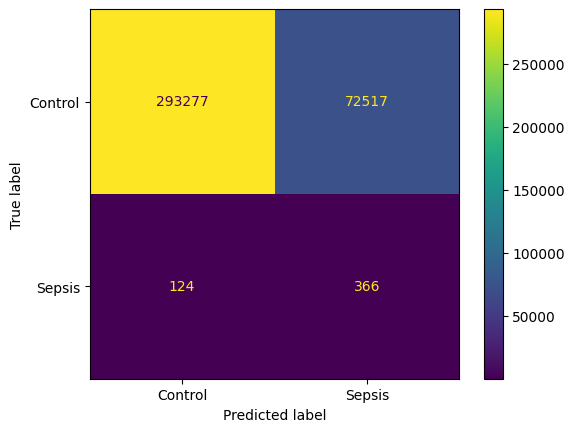

In [35]:
evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

## Error evaluation

In [ ]:
import time

number_of_iter = 100-13
dataframes =[]
gnn_models = []
times = []
for i in range(number_of_iter):
#     print(i)
    graph = graph.to(device)
    start = time.time()
    model_wrapper = ModelWrapper(graph)
    model_wrapper.train()
    times.append(time.time()-start)
    print(time.time()- start)
    model = model_wrapper.get_model()
    model = model.cpu()
    graph = graph.cpu()
    df = evaluation.get_df_metrics(model)
    print(df)
    dataframes.append(df)
    gnn_models.append(model)

In [ ]:
for t in times:
    print(t)

In [ ]:
for df in dataframes:
    print(df)

## Maintain connection

In [ ]:
import time 
for i in range(60*24):
    print("Waiting")
    time.sleep(60)